### Bot Detection using Digital DNA Compression

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp "/content/drive/MyDrive/Cresci17/cresci-2017.csv.zip" "data.zip"

!unzip data.zip
!unzip /content/datasets_full.csv/crowdflower_results.csv.zip
!unzip /content/datasets_full.csv/fake_followers.csv.zip
!unzip /content/datasets_full.csv/genuine_accounts.csv.zip
!unzip /content/datasets_full.csv/social_spambots_1.csv.zip
!unzip /content/datasets_full.csv/social_spambots_2.csv.zip
!unzip /content/datasets_full.csv/social_spambots_3.csv.zip
!unzip /content/datasets_full.csv/social_spambots_4.csv.zip
!unzip /content/datasets_full.csv/traditional_spambots_1.csv.zip
!unzip /content/datasets_full.csv/traditional_spambots_2.csv.zip
!unzip /content/datasets_full.csv/traditional_spambots_3.csv.zip
!unzip /content/datasets_full.csv/traditional_spambots_4.csv.zip

Archive:  data.zip
replace datasets_full.csv/crowdflower_results.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/datasets_full.csv/crowdflower_results.csv.zip
replace crowdflower_results.csv/crowdflower_results_aggregated.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/datasets_full.csv/fake_followers.csv.zip
replace fake_followers.csv/tweets.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/datasets_full.csv/genuine_accounts.csv.zip
replace genuine_accounts.csv/tweets.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [ ]:
import random
import sys
import time
import zlib

In [ ]:
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
from scipy.stats import ttest_1samp

<hr>

### Digital DNA

Model account behaviour by defining the following alphabet, of cardinality N = 3,

$B^3_{type} = {\{A, C, T\}}$

A $\leftarrow$ tweet,

C $\leftarrow$ reply,

T $\leftarrow$ retweet

<hr>

#### Datasets

User profile data.

In [ ]:
### Users

# Genuine accounts.
gen = pd.read_csv('/content/genuine_accounts.csv/users.csv')

# Social spambots.
ss1 = pd.read_csv('/content/social_spambots_1.csv/users.csv')
ss2 = pd.read_csv('/content/social_spambots_2.csv/users.csv')
ss3 = pd.read_csv('/content/social_spambots_3.csv/users.csv')

# Traditional spambots.
ts1 = pd.read_csv('/content/traditional_spambots_1.csv/users.csv')
ts2 = pd.read_csv('/content/traditional_spambots_2.csv/users.csv')
ts3 = pd.read_csv('/content/traditional_spambots_3.csv/users.csv')
ts4 = pd.read_csv('/content/traditional_spambots_4.csv/users.csv')

In [ ]:
!head '/content/social_spambots_1.csv/users.csv'

"id","name","screen_name","statuses_count","followers_count","friends_count","favourites_count","listed_count","url","lang","time_zone","location","default_profile","default_profile_image","geo_enabled","profile_image_url","profile_banner_url","profile_use_background_image","profile_background_image_url_https","profile_text_color","profile_image_url_https","profile_sidebar_border_color","profile_background_tile","profile_sidebar_fill_color","profile_background_image_url","profile_background_color","profile_link_color","utc_offset","is_translator","follow_request_sent","protected","verified","notifications","description","contributors_enabled","following","created_at","timestamp","crawled_at","updated","test_set_1"
"24858289","Davide Bertoli","davideb66","1299","22","40","1","0",,"it","Rome",,"1","1","1","http://abs.twimg.com/sticky/default_profile_images/default_profile_1_normal.png",NULL,"1","https://abs.twimg.com/images/themes/theme1/bg.png","333333","https://abs.twimg.com/sticky/def

Tweets.

In [ ]:
### Tweets

# Genuine accounts.
gen_tweets = pd.read_csv('/content/genuine_accounts.csv/tweets.csv', sep=",", encoding='Latin-1')

# Social spambots.
ss1_tweets = pd.read_csv('/content/social_spambots_1.csv/tweets.csv', sep=",", encoding='Latin-1')
ss2_tweets = pd.read_csv('/content/social_spambots_2.csv/tweets.csv', sep=",", encoding='Latin-1')
ss3_tweets = pd.read_csv('/content/social_spambots_3.csv/tweets.csv', sep=",", encoding='Latin-1')

# Traditional spambots.
ts1_tweets = pd.read_csv('/content/traditional_spambots_1.csv/tweets.csv', sep=",", encoding='Latin-1')

<hr>

#### Digital DNA.

In [ ]:
def create_dna_from_tweets(tweets_df):
  # Add columns for counts of tweets, replies and retweets.
    tweets_df['num_retweets'] = np.where(tweets_df['retweeted_status_id'] == 0, 0, 1)
    tweets_df['num_replies'] = np.where(tweets_df['in_reply_to_status_id'] == 0, 0, 1)
    tweets_df['num_tweets'] = np.where((tweets_df['num_retweets'] == 0) & (tweets_df['num_replies'] == 0), 1, 0)

    # DNA alphabet for tweet (A), retweet (C) and reply (T).
    tweets = tweets_df['num_tweets'] == 1
    retweets = tweets_df['num_retweets'] == 1
    replies = tweets_df['num_replies'] == 1

    tweets_df.loc[:, 'DNA'] = np.where(retweets, 'C', np.where(replies, 'T', 'A'))
    tweets_df.loc[:, 'new_DNA'] = np.where(tweets_df['num_hashtags'] > 0 , np.where(tweets_df['num_urls'] > 0, tweets_df['DNA']+'HU',tweets_df['DNA']+ 'H'), np.where(tweets_df['num_urls'] > 0, tweets_df['DNA']+'U', tweets_df['DNA']))
    # Sort tweets by timestamp..
    tweets_df = tweets_df[['user_id', 'timestamp', 'new_DNA']]
    tweets_df = tweets_df.sort_values(by=['timestamp'])

    # Create digital DNA string for each user account.
    dna = tweets_df.groupby(by=['user_id'])['new_DNA'].agg(lambda x: ''.join(x))
    
    return dna

In [ ]:
def compress_dna_df(dna):
    '''Return a dataframe with compression facts for a series of dna.'''

    # Convert DNA in string object to bytes object.
    dna_bytes = dna.apply(lambda s: s.encode('utf-8'))

    # Run compression on each DNA string in the sample.
    dna_compressed = dna_bytes.apply(lambda b: zlib.compress(b))

    # Create dataframe with compression facts.
    dna_df = pd.DataFrame({'dna': dna,
                           'original_dna_size': dna_bytes.apply(sys.getsizeof), 
                           'compressed_dna_size': dna_compressed.apply(sys.getsizeof)})
    
    dna_df['compression_ratio'] = dna_df['original_dna_size'] / dna_df['compressed_dna_size']
    
    return dna_df

<hr>

Create DNA strings based on behaviour activity for each account.

In [ ]:
gen_dna = create_dna_from_tweets(gen_tweets)

ss1_dna = create_dna_from_tweets(ss1_tweets)
ss2_dna = create_dna_from_tweets(ss2_tweets)
ss3_dna = create_dna_from_tweets(ss3_tweets)

ts1_dna = create_dna_from_tweets(ts1_tweets)

Compression on digital DNA strings.

In [ ]:
gen_dna = compress_dna_df(gen_dna)

ss1_dna = compress_dna_df(ss1_dna)
ss2_dna = compress_dna_df(ss2_dna)
ss3_dna = compress_dna_df(ss3_dna)

ts1_dna = compress_dna_df(ts1_dna)

bot_dna = pd.concat([ss1_dna, ss2_dna, ss3_dna])

<hr>

#### Visualise compression facts for accounts.

In [ ]:
# Add a column for account type to the dataframes.
gen_dna['Account Type'] = 'Genuine'
bot_dna['Account Type'] = 'Bot'

# Combine all samples into a single dataframe.
all_dna = pd.concat([gen_dna, bot_dna])

In [ ]:
all_dna.sample(5)

,dna,original_dna_size,compressed_dna_size,compression_ratio,Account Type
user_id,,,,,
2.351640e+09,AAAAHAAAAAAAAHAATAATAATATAHAAATATAATAATHATAATH...,172,86,2.000000,Bot
2.355704e+09,AAAAAAAAAATHAATAATTAATAHATTAATAATAAAAAAAATHAAA...,147,79,1.860759,Bot
2.376967e+09,AAAAATAATAATTAATAATATHAATAATAATAHATAHATAAAAAAT...,109,72,1.513889,Bot
5.494162e+08,CCCCCAAAAAAAAACCHCCAAAACACCCAAAAAACCCCCHACCCTA...,3627,1090,3.327523,Genuine
2.354285e+09,AAAAAAAAAAAAAAAATAATAATAATAATAATAATAATHAAAAAAA...,165,77,2.142857,Bot


##### Plot of Uncompressed DNA Size vs. Compressed DNA Size.

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#2
1. Social Spambots \#3
1. Traditional Spambots \#1

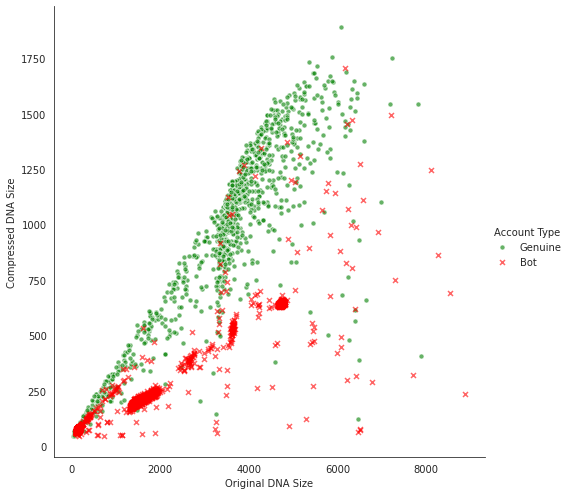

In [ ]:
sns.set_style("white")

pal = {
    'Genuine': 'green',
    'Bot': 'red'
}

g = sns.FacetGrid(all_dna, hue='Account Type', palette=pal, size=7, hue_kws=dict(marker=["o", "x"]))
g.map(plt.scatter, "original_dna_size", "compressed_dna_size", s=25, alpha=.6, edgecolor="white")
g.add_legend()
g.set_axis_labels('Original DNA Size', 'Compressed DNA Size')

##### Plot of DNA Size vs. Compression Ratio.

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#2
1. Social Spambots \#3
1. Traditional Spambots \#1

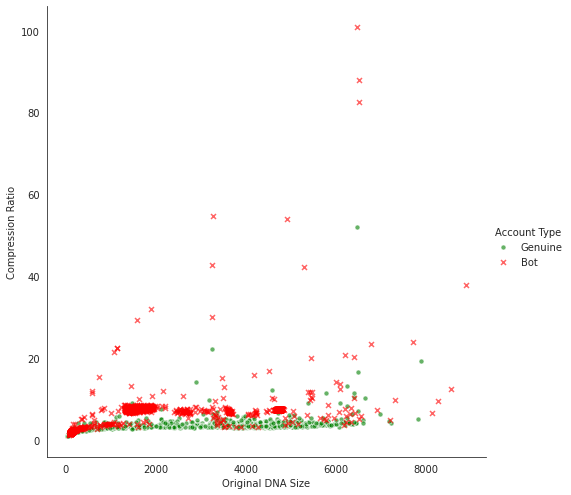

In [ ]:
sns.set_style("white")

pal = {
    'Genuine': 'green',
    'Bot': 'red'
}

g = sns.FacetGrid(all_dna, hue='Account Type', palette=pal, size=7, hue_kws=dict(marker=["o", "x"]))
g.map(plt.scatter, "original_dna_size", "compression_ratio", s=25, alpha=.6, edgecolor="white")
g.add_legend()
g.set_axis_labels('Original DNA Size', 'Compression Ratio')

##### Historgram for Compression Ratio

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#2
1. Social Spambots \#3
1. Traditional Spambots \#1

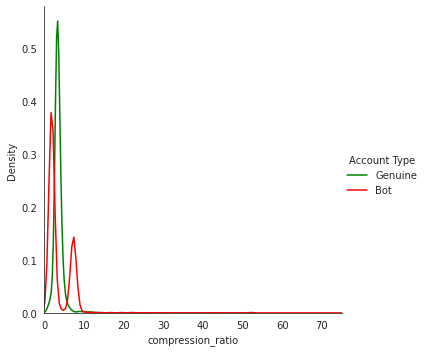

In [ ]:
g = sns.FacetGrid(all_dna, hue='Account Type', palette=pal, size=5)
g.set(xlim=(0, 75))
g.map(sns.kdeplot, 'compression_ratio')
g.add_legend()

<hr>

Evaluation Metrics
1. Accuracy
1. Precision
1. Recall
1. F1 Score
1. Specificity
1. MCC

In [ ]:
def evaluate(y_test, predictions):
    '''Return a dataframe with accuracy, precision, recall and f1 scores for predictions.'''
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    specificity = tn / (tn+fp)
    
    results = [
        {
            'Metric': 'Accuracy',
            'Score': accuracy_score(y_test, predictions)
        },
        {
            'Metric': 'Precision',
            'Score': precision_score(y_test, predictions)
        },
        {
            'Metric': 'Recall',
            'Score': recall_score(y_test, predictions)
        },
        {
            'Metric': 'F1 Score',
            'Score': f1_score(y_test, predictions)
        },
        {
            'Metric': 'MCC',
            'Score': matthews_corrcoef(y_test, predictions)
        },
        {
            'Metric': 'Specificity',
            'Score': specificity
        },
    ]

    return pd.DataFrame(results)

<hr>

In [ ]:
def train_predict_evaluate(dna, features, test_size=0.5):
    '''Train a Logistic Regression model with given features
    using default parameters on a random sample of data.'''

    # Randomly shuffle the dna dataframe.
    dna = utils.shuffle(dna)

    # Features and labels.
    X = dna[features]
    y = dna.loc[:, 'label']

    # Split the dataset for training and testing using Logistic Regression.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Logistic Regression classifier with default parameters.
    classifier = LogisticRegression()

    # Train the classifier.
    start_train = time.time()
    classifier.fit(X_train, y_train)
    end_train = time.time()

    # Make predictions on the test set.
    start_test = time.time()
    predictions = classifier.predict(X_test)
    end_test = time.time()

    # Evaluation on the test set.
    results = evaluate(y_test, predictions)

    return results

<hr>

Results for k-common substring

In [ ]:
k_common_substring_1 = pd.DataFrame({'Supervised': [0.977, 0.977, 0.955, 0.982, 0.977, 0.981],
                                     'Unsupervised': [0.976, 0.977, 0.952, 0.982, 0.972, 0.981]}, 
                                    index=['Accuracy', 'F1 Score', 'MCC', 'Precision', 'Recall', 'Specificity'])


In [ ]:
k_common_substring_2 = pd.DataFrame({'Supervised': [0.970, 0.970, 0.940, 0.978, 0.961, 0.979], 
                                     'Unsupervised': [0.929, 0.923, 0.867, 1.000, 0.858, 1.000]},
                                    index=['Accuracy', 'F1 Score', 'MCC', 'Precision', 'Recall', 'Specificity'])

<hr>

## Test Set #1

In [ ]:
# Genuine accounts in test set 1.
gen_test1 = gen[gen['test_set_1'] == 1]

# Social spambots in test set 1.
ss1_test_1 = ss1[ss1['test_set_1'] == 1]


# Tweets for genuine accounts in test set 1.
gen_tweets_test1 = gen_tweets[gen_tweets['user_id'].isin(gen_test1['id'])]

# Tweets for spambot accounts in test set 1.
ss1_tweets_test1 = ss1_tweets[ss1_tweets['user_id'].isin(ss1_test_1['id'])]


# DNA for genuine accounts in test set 1.
gen_dna_test1 = create_dna_from_tweets(gen_tweets_test1)

# DNA for spambots in test set 1.
ss1_dna_test1 = create_dna_from_tweets(ss1_tweets_test1)


# DNA string compression for genuine accounts in test set 1.
gen_dna_test1 = compress_dna_df(gen_dna_test1)

# DNA string compression for spambots in test set 1.
ss1_dna_test1 = compress_dna_df(ss1_dna_test1)


# Add a column for label to the dataframes.
gen_dna_test1['label'] = 0
ss1_dna_test1['label'] = 1

There are some accounts for which there are no tweets, set an empty string as the DNA sequence for such accounts.

In [ ]:
sys.getsizeof(''.encode('utf-8'))   # size in bytes of empty string

33

In [ ]:
sys.getsizeof(zlib.compress(''.encode('utf-8')))    # size in bytes of compressed empty string

41

In [ ]:
# compression ratio for empty string
sys.getsizeof(''.encode('utf-8')) / sys.getsizeof(zlib.compress(''.encode('utf-8')))

0.8048780487804879

In [ ]:
gen_with_no_tweets_test1 = gen_test1[~gen_test1['id'].isin(gen_dna_test1.index)]

gen_with_no_tweets_dna_test1 = pd.DataFrame({'id': gen_with_no_tweets_test1['id'], 
                                             'original_dna_size': 33, 
                                             'compressed_dna_size': 41, 
                                             'compression_ratio': 0.80, 
                                             'label': 0})

gen_with_no_tweets_dna_test1 = gen_with_no_tweets_dna_test1.set_index('id')

gen_dna_test1 = pd.concat([gen_dna_test1, gen_with_no_tweets_dna_test1])

# Combine test set 1 accounts into a single dataframe.
dna_test1 = pd.concat([gen_dna_test1, ss1_dna_test1])

In [ ]:
dna_test1.sample(5)

,dna,original_dna_size,compressed_dna_size,compression_ratio,label
4.828655e+08,AUAUAUAUAUAUAUAUCUCUCUCUAUAUAUAUAUAUCUCUAUAUCU...,6983,1105,6.319457,0
2.257463e+09,AAAAUAAAAAAAAAAAAAAAACHAAAAAAAUACHAAAAAHAAAAAA...,1689,214,7.892523,1
2.926713e+07,NaN,33,41,0.800000,0
8.143711e+07,NaN,33,41,0.800000,0
4.128675e+08,NaN,33,41,0.800000,0


1. Logistic Regression with Original DNA Size + Compressed DNA Size

In [ ]:
results = pd.DataFrame()

for i in range(1000):
    np.random.seed(i)
    results = pd.concat([results, train_predict_evaluate(dna_test1, ['original_dna_size', 'compressed_dna_size'])])

# Compute average scores for each metric
results_with_length = results.groupby(by=['Metric']) \
               .mean() \
               .rename({'Score': 'Mean'}, axis=1) \
               .join(results.groupby(by=['Metric'])
                            .std() \
                            .rename({'Score': 'Std.'}, axis=1))

# Compute statistical significance against the method k-common-substring for DNA sequences
stat_sig = []
for metric in k_common_substring_1.index:
    s = dict()

    ts, ps = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Supervised'][metric])
    tu, pu = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Unsupervised'][metric])

    s['Metric'] = metric
    s['t-supervised'] = round(ts, 4)
    s['t-unsupervised'] = round(tu, 4)
    s['p-supervised'] = round(ps, 4)
    s['p-unsupervised'] = round(pu, 4)
    s['Mean'] = results[results['Metric'] == metric]['Score'].mean()
    s['SD'] = results[results['Metric'] == metric]['Score'].std()
    s['k-supervised'] = k_common_substring_1['Supervised'][metric]
    s['k-unsupervised'] = k_common_substring_1['Unsupervised'][metric]
    
    stat_sig.append(s)

stat_sig = pd.DataFrame(stat_sig).set_index(['Metric'])

stat_sig

,t-supervised,t-unsupervised,p-supervised,p-unsupervised,Mean,SD,k-supervised,k-unsupervised
Metric,,,,,,,,
Accuracy,12.1532,20.8055,0.0,0.0,0.978405,0.003655,0.977,0.976
F1 Score,12.5109,12.5109,0.0,0.0,0.978450,0.003666,0.977,0.977
MCC,8.4933,21.6339,0.0,0.0,0.956939,0.007219,0.955,0.952
Precision,-42.1783,-42.1783,0.0,0.0,0.971727,0.007702,0.982,0.982
Recall,58.8883,94.2637,0.0,0.0,0.985323,0.004470,0.977,0.972
Specificity,-38.0867,-38.0867,0.0,0.0,0.971558,0.007840,0.981,0.981


2. Logistic Regression with Original DNA Size + Compression Ratio

In [ ]:
results = pd.DataFrame()
for i in range(1000):
    np.random.seed(i)
    results = pd.concat([results, train_predict_evaluate(dna_test1, ['original_dna_size', 'compression_ratio'])])

# Compute average scores for each metric
results_with_ratio = results.groupby(by=['Metric']) \
               .mean() \
               .rename({'Score': 'Mean'}, axis=1) \
               .join(results.groupby(by=['Metric'])
                            .std() \
                            .rename({'Score': 'Std.'}, axis=1))

# Compute statistical significance against the method k-common-substring for DNA sequences
stat_sig = []
for metric in k_common_substring_1.index:
    s = dict()

    ts, ps = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Supervised'][metric])
    tu, pu = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Unsupervised'][metric])

    s['Metric'] = metric
    s['t-supervised'] = round(ts, 4)
    s['t-unsupervised'] = round(tu, 4)
    s['p-supervised'] = round(ps, 4)
    s['p-unsupervised'] = round(pu, 4)
    s['Mean'] = results[results['Metric'] == metric]['Score'].mean()
    s['SD'] = results[results['Metric'] == metric]['Score'].std()
    s['k-supervised'] = k_common_substring_1['Supervised'][metric]
    s['k-unsupervised'] = k_common_substring_1['Unsupervised'][metric]
    
    stat_sig.append(s)

stat_sig = pd.DataFrame(stat_sig).set_index(['Metric'])

stat_sig

,t-supervised,t-unsupervised,p-supervised,p-unsupervised,Mean,SD,k-supervised,k-unsupervised
Metric,,,,,,,,
Accuracy,42.3502,52.8066,0.0000,0.0000,0.981050,0.003024,0.977,0.976
F1 Score,40.4271,40.4271,0.0000,0.0000,0.980953,0.003092,0.977,0.977
MCC,37.1994,52.8878,0.0000,0.0000,0.962113,0.006047,0.955,0.952
Precision,-6.4283,-6.4283,0.0000,0.0000,0.980945,0.005190,0.982,0.982
Recall,26.1068,58.8052,0.0000,0.0000,0.980992,0.004836,0.977,0.972
Specificity,0.6850,0.6850,0.4935,0.4935,0.981111,0.005137,0.981,0.981


In [ ]:
print('String Compression - Compressed DNA Size &',
      '{:.3f} &'.format(results_with_length['Mean']['Accuracy']),
      '{:.3f} &'.format(results_with_length['Mean']['Precision']),
      '{:.3f} &'.format(results_with_length['Mean']['Recall']),
      '{:.3f} &'.format(results_with_length['Mean']['F1 Score']),
      '{:.3f} &'.format(results_with_length['Mean']['MCC']),
      '{:.3f} \\\\'.format(results_with_length['Mean']['Specificity']))

print('String Compression - Compression Ratio &',
      '{:.3f} &'.format(results_with_ratio['Mean']['Accuracy']),
      '{:.3f} &'.format(results_with_ratio['Mean']['Precision']),
      '{:.3f} &'.format(results_with_ratio['Mean']['Recall']),
      '{:.3f} &'.format(results_with_ratio['Mean']['F1 Score']),
      '{:.3f} &'.format(results_with_ratio['Mean']['MCC']),
      '{:.3f} \\\\'.format(results_with_ratio['Mean']['Specificity']))

String Compression - Compressed DNA Size & 0.978 & 0.972 & 0.985 & 0.978 & 0.957 & 0.972 \\
String Compression - Compression Ratio & 0.981 & 0.981 & 0.981 & 0.981 & 0.962 & 0.981 \\


<hr>

## Test Set #2

In [ ]:
# Genuine accounts in test set 2.
gen_test2 = gen[gen['test_set_2'] == 1]

# Social spambots in test set 2.
ss3_test_2 = ss3[ss3['test_set_2'] == 1]


# Tweets for genuine accounts in test set 2.
gen_tweets_test2 = gen_tweets[gen_tweets['user_id'].isin(gen_test2['id'])]

# Tweets for spambot accounts in test set 2.
ss3_tweets_test2 = ss3_tweets[ss3_tweets['user_id'].isin(ss3_test_2['id'])]


# DNA for genuine accounts in test set 2.
gen_dna_test2 = create_dna_from_tweets(gen_tweets_test2)

# DNA for spambots in test set 2.
ss3_dna_test2 = create_dna_from_tweets(ss3_tweets_test2)


# DNA string compression for genuine accounts in test set 2.
gen_dna_test2 = compress_dna_df(gen_dna_test2)

# DNA string compression for spambots in test set 2.
ss3_dna_test2 = compress_dna_df(ss3_dna_test2)


# Add a column for label to the dataframes.
gen_dna_test2['label'] = 0
ss3_dna_test2['label'] = 1


# Combine test set 2 accounts into a single dataframe.
dna_test2 = pd.concat([gen_dna_test2, ss3_dna_test2])

In [ ]:
gen_with_no_tweets_test2 = gen_test2[~gen_test2['id'].isin(gen_dna_test2.index)]

gen_with_no_tweets_dna_test2 = pd.DataFrame({'id': gen_with_no_tweets_test2['id'], 
                                             'original_dna_size': 33, 
                                             'compressed_dna_size': 41, 
                                             'compression_ratio': 0.80, 
                                             'label': 0})

gen_with_no_tweets_dna_test2 = gen_with_no_tweets_dna_test2.set_index('id')

gen_dna_test2 = pd.concat([gen_dna_test2, gen_with_no_tweets_dna_test2])

# Combine test set 1 accounts into a single dataframe.
dna_test2 = pd.concat([gen_dna_test2, ss3_dna_test2])

1. Logistic Regression with Original DNA Size + Compressed DNA Size

In [ ]:
results = pd.DataFrame()

for i in range(1000):
    np.random.seed(i)
    results = pd.concat([results, train_predict_evaluate(dna_test2, ['original_dna_size', 'compressed_dna_size'])])

results_with_length = results.groupby(by=['Metric']) \
                           .mean() \
                           .rename({'Score': 'Mean'}, axis=1) \
                           .join(results.groupby(by=['Metric'])
                                        .std() \
                                        .rename({'Score': 'Std.'}, axis=1))
# Compute average scores for each metric
results_with_length = results.groupby(by=['Metric']) \
               .mean() \
               .rename({'Score': 'Mean'}, axis=1) \
               .join(results.groupby(by=['Metric'])
                            .std() \
                            .rename({'Score': 'Std.'}, axis=1))

# Compute statistical significance against the method k-common-substring for DNA sequences
stat_sig = []
for metric in k_common_substring_2.index:
    s = dict()

    ts, ps = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_2['Supervised'][metric])
    tu, pu = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_2['Unsupervised'][metric])

    s['Metric'] = metric
    s['t-supervised'] = round(ts, 4)
    s['t-unsupervised'] = round(tu, 4)
    s['p-supervised'] = round(ps, 4)
    s['p-unsupervised'] = round(pu, 4)
    s['Mean'] = results[results['Metric'] == metric]['Score'].mean()
    s['SD'] = results[results['Metric'] == metric]['Score'].std()
    s['k-supervised'] = k_common_substring_2['Supervised'][metric]
    s['k-unsupervised'] = k_common_substring_2['Unsupervised'][metric]
    
    stat_sig.append(s)

stat_sig = pd.DataFrame(stat_sig).set_index(['Metric'])

stat_sig

,t-supervised,t-unsupervised,p-supervised,p-unsupervised,Mean,SD,k-supervised,k-unsupervised
Metric,,,,,,,,
Accuracy,-20.1159,184.9974,0.0,0.0,0.965979,0.006321,0.970,0.929
F1 Score,-26.4214,195.8790,0.0,0.0,0.964414,0.006686,0.970,0.923
MCC,-19.5438,165.7142,0.0,0.0,0.932299,0.012461,0.940,0.867
Precision,8.2938,-89.4580,0.0,0.0,0.979867,0.007117,0.978,1.000
Recall,-31.2492,249.6519,0.0,0.0,0.949542,0.011595,0.961,0.858
Specificity,12.1484,-88.4797,0.0,0.0,0.981535,0.006599,0.979,1.000


2. Logistic Regression with Original DNA Size + Compression Ratio

In [ ]:
results = pd.DataFrame()
for i in range(1000):
    np.random.seed(i)
    results = pd.concat([results, train_predict_evaluate(dna_test2, ['original_dna_size', 'compression_ratio'])])

# Compute average scores for each metric
results_with_ratio = results.groupby(by=['Metric']) \
               .mean() \
               .rename({'Score': 'Mean'}, axis=1) \
               .join(results.groupby(by=['Metric'])
                            .std() \
                            .rename({'Score': 'Std.'}, axis=1))

# Compute statistical significance against the method k-common-substring for DNA sequences
stat_sig = []
for metric in k_common_substring_2.index:
    s = dict()

    ts, ps = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_2['Supervised'][metric])
    tu, pu = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_2['Unsupervised'][metric])

    s['Metric'] = metric
    s['t-supervised'] = round(ts, 4)
    s['t-unsupervised'] = round(tu, 4)
    s['p-supervised'] = round(ps, 4)
    s['p-unsupervised'] = round(pu, 4)
    s['Mean'] = results[results['Metric'] == metric]['Score'].mean()
    s['SD'] = results[results['Metric'] == metric]['Score'].std()
    s['k-supervised'] = k_common_substring_2['Supervised'][metric]
    s['k-unsupervised'] = k_common_substring_2['Unsupervised'][metric]
    
    stat_sig.append(s)

stat_sig = pd.DataFrame(stat_sig).set_index(['Metric'])

stat_sig

,t-supervised,t-unsupervised,p-supervised,p-unsupervised,Mean,SD,k-supervised,k-unsupervised
Metric,,,,,,,,
Accuracy,9.5155,231.0558,0.0000,0.0,0.971761,0.005852,0.970,0.929
F1 Score,3.9126,248.0753,0.0001,0.0,0.970753,0.006087,0.970,0.923
MCC,9.6518,207.4986,0.0000,0.0,0.943561,0.011668,0.940,0.867
Precision,-5.6961,-90.8000,0.0000,0.0,0.976528,0.008175,0.978,1.000
Recall,12.7215,328.5656,0.0000,0.0,0.965149,0.010313,0.961,0.858
Specificity,-3.9395,-89.4067,0.0001,0.0,0.978032,0.007770,0.979,1.000


In [ ]:
print('String Compression - Compressed DNA Size &',
      '{:.3f} &'.format(results_with_length['Mean']['Accuracy']),
      '{:.3f} &'.format(results_with_length['Mean']['Precision']),
      '{:.3f} &'.format(results_with_length['Mean']['Recall']),
      '{:.3f} &'.format(results_with_length['Mean']['F1 Score']),
      '{:.3f} &'.format(results_with_length['Mean']['MCC']),
      '{:.3f} \\\\'.format(results_with_length['Mean']['Specificity']))

print('String Compression - Compression Ratio &',
      '{:.3f} &'.format(results_with_ratio['Mean']['Accuracy']),
      '{:.3f} &'.format(results_with_ratio['Mean']['Precision']),
      '{:.3f} &'.format(results_with_ratio['Mean']['Recall']),
      '{:.3f} &'.format(results_with_ratio['Mean']['F1 Score']),
      '{:.3f} &'.format(results_with_ratio['Mean']['MCC']),
      '{:.3f} \\\\'.format(results_with_ratio['Mean']['Specificity']))

String Compression - Compressed DNA Size & 0.966 & 0.980 & 0.950 & 0.964 & 0.932 & 0.982 \\
String Compression - Compression Ratio & 0.972 & 0.977 & 0.965 & 0.971 & 0.944 & 0.978 \\


<hr>

#### Compression Statistics over the test sets

In [ ]:
# Filter genuine accounts and bot accounts to compute statistics for each group.
g = all_dna['Account Type'] == 'Genuine'
b = all_dna['Account Type'] == 'Bot'

In [ ]:
compression_stats = pd.DataFrame({'Mean Length': [all_dna['dna'].apply(len).mean(), 
                                                  all_dna[g]['dna'].apply(len).mean(), 
                                                  all_dna[b]['dna'].apply(len).mean()],
                                  'SD Length': [all_dna['dna'].apply(len).std(), 
                                                all_dna[g]['dna'].apply(len).std(), 
                                                all_dna[b]['dna'].apply(len).std()],
                                  'Mean Uncompressed Size': [all_dna['original_dna_size'].mean(), 
                                                             all_dna[g]['original_dna_size'].mean(), 
                                                             all_dna[b]['original_dna_size'].mean()],
                                  'SD Uncompressed Size': [all_dna['original_dna_size'].std(), 
                                                            all_dna[g]['original_dna_size'].std(), 
                                                           all_dna[b]['original_dna_size'].std()],
                                  'Mean Compressed Size': [all_dna['compressed_dna_size'].mean(), 
                                                           all_dna[g]['compressed_dna_size'].mean(), 
                                                           all_dna[b]['compressed_dna_size'].mean()],
                                  'SD Compressed Size': [all_dna['compressed_dna_size'].std(), 
                                                         all_dna[g]['compressed_dna_size'].std(), 
                                                         all_dna[b]['compressed_dna_size'].std()],
                                  'Mean Compressio Ratio': [all_dna['compression_ratio'].mean(), 
                                                            all_dna[g]['compression_ratio'].mean(), 
                                                            all_dna[b]['compression_ratio'].mean()],
                                  'SD Compressio Ratio': [all_dna['compression_ratio'].std(), 
                                                          all_dna[g]['compression_ratio'].std(), 
                                                          all_dna[b]['compression_ratio'].std()]},
                                 index=['All', 'Genuine', 'Bot'])

In [ ]:
compression_stats

,Mean Length,SD Length,Mean Uncompressed Size,SD Uncompressed Size,Mean Compressed Size,SD Compressed Size,Mean Compressio Ratio,SD Compressio Ratio
All,1349.887740,1757.896992,1382.887740,1757.896992,310.220851,389.941324,3.683811,3.491343
Genuine,3425.925208,1454.120298,3458.925208,1454.120298,962.935365,403.102824,3.665209,1.996763
Bot,892.162052,1464.855718,925.162052,1464.855718,166.310057,187.401260,3.687912,3.741529


In [ ]:
print('All &',
      '{:.2f} & '.format(compression_stats['Mean Length']['All']),
      '{:.2f} & '.format(compression_stats['SD Length']['All']),
      '{:.2f} & '.format(compression_stats['Mean Uncompressed Size']['All']),
      '{:.2f} & '.format(compression_stats['SD Uncompressed Size']['All']),
      '{:.2f} & '.format(compression_stats['Mean Compressed Size']['All']),
      '{:.2f} & '.format(compression_stats['SD Compressed Size']['All']),
      '{:.2f} & '.format(compression_stats['Mean Compressio Ratio']['All']),
      '{:.2f} \\\\ '.format(compression_stats['SD Compressio Ratio']['All']),
     )

print('Genuine &',
      '{:.2f} & '.format(compression_stats['Mean Length']['Genuine']),
      '{:.2f} & '.format(compression_stats['SD Length']['Genuine']),
      '{:.2f} & '.format(compression_stats['Mean Uncompressed Size']['Genuine']),
      '{:.2f} & '.format(compression_stats['SD Uncompressed Size']['Genuine']),
      '{:.2f} & '.format(compression_stats['Mean Compressed Size']['Genuine']),
      '{:.2f} & '.format(compression_stats['SD Compressed Size']['Genuine']),
      '{:.2f} & '.format(compression_stats['Mean Compressio Ratio']['Genuine']),
      '{:.2f} \\\\ '.format(compression_stats['SD Compressio Ratio']['Genuine']),
     )

print('Bot &',
      '{:.2f} & '.format(compression_stats['Mean Length']['Bot']),
      '{:.2f} & '.format(compression_stats['SD Length']['Bot']),
      '{:.2f} & '.format(compression_stats['Mean Uncompressed Size']['Bot']),
      '{:.2f} & '.format(compression_stats['SD Uncompressed Size']['Bot']),
      '{:.2f} & '.format(compression_stats['Mean Compressed Size']['Bot']),
      '{:.2f} & '.format(compression_stats['SD Compressed Size']['Bot']),
      '{:.2f} & '.format(compression_stats['Mean Compressio Ratio']['Bot']),
      '{:.2f} \\\\ '.format(compression_stats['SD Compressio Ratio']['Bot']),
     )

All & 1349.89 &  1757.90 &  1382.89 &  1757.90 &  310.22 &  389.94 &  3.68 &  3.49 \\ 
Genuine & 3425.93 &  1454.12 &  3458.93 &  1454.12 &  962.94 &  403.10 &  3.67 &  2.00 \\ 
Bot & 892.16 &  1464.86 &  925.16 &  1464.86 &  166.31 &  187.40 &  3.69 &  3.74 \\ 


#### Histogram of compression ratio

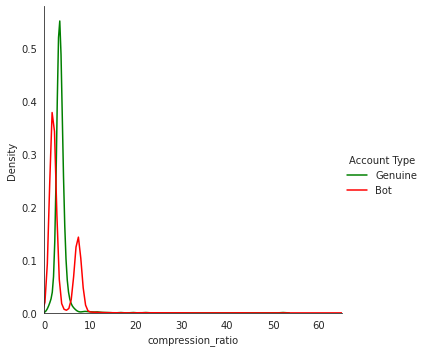

In [ ]:
g = sns.FacetGrid(all_dna, hue='Account Type', palette=pal, height=5)
g.set(xlim=(0, 65))
g.map(sns.kdeplot, 'compression_ratio')
g.add_legend()

#### Boxplot of compression ratio

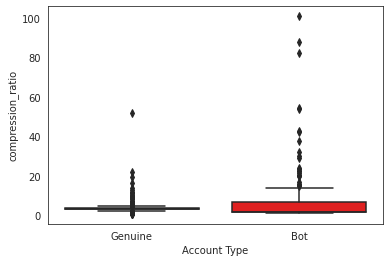

In [ ]:
sns.boxplot(data=all_dna, x='Account Type', y='compression_ratio', palette=pal, orient='v')

<hr>

##### Plot of Uncompressed DNA Size vs. Compressed DNA Size.

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#3

findfont: Font family ['Source Sans Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Source Sans Pro'] not found. Falling back to DejaVu Sans.


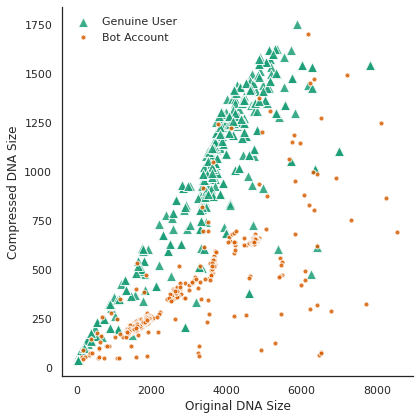

In [ ]:
dna_all = pd.concat([dna_test1, dna_test2]).rename({'label': 'Account Type'}, axis=1)
dna_all['Account Type'] = np.where(dna_all['Account Type'] == 0, 'Genuine User', 'Bot Account')

sns.set(style='white', font='Source Sans Pro')

pal = {
    'Genuine User': sns.color_palette('Dark2')[0],
    'Bot Account':  sns.color_palette('Dark2')[1]
}

g = sns.FacetGrid(dna_all, hue='Account Type', 
                  palette=pal, height=6, hue_kws=dict(marker=["^", "."]))
g.map(plt.scatter, "original_dna_size", "compressed_dna_size", s=100, alpha=0.85, edgecolor="white")
# g.add_legend()
plt.legend(loc='upper left', frameon=False)
g.set_axis_labels('Original DNA Size', 'Compressed DNA Size')
g.savefig('dna-scatter-1.pdf')

##### Plot of DNA Size vs. Compression Ratio.

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#3

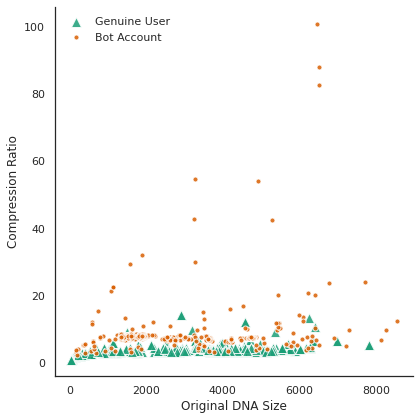

In [ ]:
dna_all = pd.concat([dna_test1, dna_test2]).rename({'label': 'Account Type'}, axis=1)
dna_all['Account Type'] = np.where(dna_all['Account Type'] == 0, 'Genuine User', 'Bot Account')

sns.set(style='white', font='Source Sans Pro')

pal = {
    'Genuine User': sns.color_palette('Dark2')[0],
    'Bot Account':  sns.color_palette('Dark2')[1]
}

g = sns.FacetGrid(dna_all, hue='Account Type', 
                  palette=pal, height=6, hue_kws=dict(marker=["^", "."]))
g.map(plt.scatter, "original_dna_size", "compression_ratio", s=100, alpha=0.85, edgecolor="white")
# g.add_legend()
plt.legend(loc='upper left', frameon=False)
g.set_axis_labels('Original DNA Size', 'Compression Ratio')
g.savefig('dna-scatter-2.pdf')

<hr>

In [ ]:
# markers = {'Genuine': '^', 'Bot': '+'}

# ax = sns.scatterplot(data=dna_all, x='original_dna_size', y='compressed_dna_size', s=50,
#                 hue='Account Type', palette=pal, style='Account Type', alpha=0.7)

# ax.set_xlabel('Original DNA Size')
# ax.set_ylabel('Compressed DNA Size')